In [66]:
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from statsmodels.formula.api import ols

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2_contingency

import datetime
import calendar

import keras
import tensorflow
from keras.models import Sequential
from keras import layers
from keras.layers import BatchNormalization, Dropout

from sklearn.metrics import r2_score as r2, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [11]:
dataset = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/Fraud_Data.csv")
IP_table = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/IpAddress_to_Country.csv")

In [12]:
dataset["time"] = pd.DataFrame(pd.to_datetime(dataset["purchase_time"]) - pd.to_datetime(dataset["signup_time"])).astype(str)
dataset["time"] = dataset["time"].apply(lambda x : x[-8:])
dataset["time"] = pd.to_datetime(dataset['time'],format= '%H:%M:%S' ).dt.time

In [13]:
device_duplicates = pd.DataFrame(dataset.groupby(by = "device_id").device_id.count())  # at this moment, index column name and first column name both are equal to "device_id"
device_duplicates.rename(columns={"device_id": "freq_device"}, inplace=True)           # hence we need to replace the "device_id" column name
device_duplicates.reset_index(level=0, inplace= True)

In [14]:
IP_table.upper_bound_ip_address.astype("float")
IP_table.lower_bound_ip_address.astype("float")
dataset.ip_address.astype("float")

# function that takes an IP address as argument and returns country associated based on IP_table

def IP_to_country(ip) :
    try :
        return IP_table.country[(IP_table.lower_bound_ip_address < ip)                            
                                & 
                                (IP_table.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return "Unknown"     
dataset["IP_country"] = dataset.ip_address.apply(IP_to_country)

In [15]:
dataset = dataset.merge(device_duplicates, on= "device_id")

# --- 1 ---
# Categorisation column freq_device
# We see a clear correlation between freq_device and fraudulent activities. We are going to split freq_device in 7 categories
dataset.freq_device = dataset.freq_device.apply(lambda x :
                                                str(x) if x <5 else
                                                "5-10" if x>=5 and x<=10 else
                                                "11-15" if x>10 and x<=15 else
                                                "> 15")

# We convert signup_time and purchase_time en datetime

dataset.signup_time = pd.to_datetime(dataset.signup_time, format = '%Y-%m-%d %H:%M:%S')
dataset.purchase_time = pd.to_datetime(dataset.purchase_time, format = '%Y-%m-%d %H:%M:%S')

# We add features 

# --- 2 ---
# Column month
dataset["month_purchase"] = dataset.purchase_time.apply(lambda x: calendar.month_name[x.month])

# --- 3 ---
# Column week
dataset["weekday_purchase"] = dataset.purchase_time.apply(lambda x: calendar.day_name[x.weekday()])

# --- 4 ---
# Column hour_of_the_day
dataset["hour_of_the_day"] = dataset.purchase_time.apply(lambda x: x.hour)

# --- 5 ---
# Column seconds_since_signup
dataset["seconds_since_signup"]= (dataset.purchase_time - dataset.signup_time).apply(lambda x : x.total_seconds())

# --- 6 ---
# Column countries_from_device (ie. number of different countries per device_id)

# We flag devices that committed purchases from different countries
# First we groupby device_id and IP_country which will give us a DF with a sublist of country for each device_id
country_count = dataset.groupby(by =[ "device_id","IP_country"]).count().reset_index()

# Then we can count the number of different countries by device_id
country_count = pd.DataFrame(country_count.groupby(by="device_id").count().IP_country)

# Finally we can merge this to our main dataset
dataset = dataset.merge(country_count, left_on="device_id", right_index=True)
dataset.rename(columns={"IP_country_x": "IP_country" , "IP_country_y":"countries_from_device"}, inplace = True)

# --- 7 ---
# Column risk_country which classifies each country based on historical fraud rate from these countries

# We calculate the proportion of fraud by country
risk_country = pd.DataFrame(dataset.groupby(by="IP_country").mean()["class"].sort_values(ascending = False))

# We classify each country between Very High risk, High risk, Medium risk and low risk
risk_country["risk_country"] = risk_country["class"].apply(lambda x : 
                                                           "Very High risk" if x > 0.25 else
                                                           "High risk" if x > 0.05 else
                                                           "Medium risk" if x > 0.01 else
                                                           "Low risk")
                                                
# We merge with dataset
dataset = dataset.merge(risk_country.drop("class", axis = 1), left_on= "IP_country", right_index = True)

# --- 8 ---
# Column "quick_purchase" : categorise time between sign_up and purchase
dataset["quick_purchase"] = dataset.seconds_since_signup.apply(lambda x : 1 if x < 30 else 0)

# --- 9 ---
# Column freq_same_purchase : indicates how many times a given device_id purchased an item of the same value

# We generate a table indicating for each line if the couple device_id / purchase_value has duplicates
duplicate = dataset.duplicated(subset = ["purchase_value","device_id"], keep = False)
# We merge it with a DF containing purchase_value and device_id
duplicate = pd.concat([dataset.loc[:,["purchase_value","device_id"]], duplicate],axis=1)
# We build a DataFrame which gives us the number of duplicates for each combination of device_id / purchase_value
duplicate = duplicate.groupby(by = ["device_id","purchase_value"]).sum()
# We categorise number of time the same purchase has been made 
duplicate["freq_same_purchase"] = duplicate[0].apply(lambda x : 
                                                x if x < 5 else
                                                "5-10" if x<=10 else
                                                "11-15" if x<= 15 else
                                                ">15" 
                                               )
                                            
# We merge the result with main dataset            
dataset = dataset.merge(duplicate.drop(0,axis=1), left_on=["device_id","purchase_value"], right_index = True)

# --- 10 ---- 
# age categorisation

dataset["age_category"] = dataset.age.apply(lambda x : 
                 "< 40" if x < 40 else
                 "40 - 49" if x < 50 else
                 "50 -59" if x < 60 else
                 "60 - 69" if x < 70 else
                 " > 70")

# ---- 11 ----
# Hour of the day categorisation
dataset["period_of_the_day"] = dataset.hour_of_the_day.apply(lambda x : 
                                                             "late night" if x < 4 else
                                                             "early morning" if x < 8 else
                                                             "morning" if x < 12 else
                                                             "early arvo" if x < 16 else
                                                             "arvo" if x < 20 else
                                                             "evening"
                                                            )

In [16]:
dataset

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,month_purchase,weekday_purchase,hour_of_the_day,seconds_since_signup,countries_from_device,risk_country,quick_purchase,freq_same_purchase,age_category,period_of_the_day
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,April,Saturday,2,4506682.0,1,High risk,0,0,< 40,late night
61,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,...,April,Thursday,17,5959702.0,1,High risk,0,0,< 40,arvo
70,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,...,August,Monday,5,662649.0,1,High risk,0,0,40 - 49,early morning
84,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,...,January,Monday,12,82537.0,2,High risk,0,0,40 - 49,early arvo
91,83866,2015-07-13 11:14:18,2015-09-20 08:18:30,33,JQYCFABXAMQVP,SEO,Chrome,F,34,7.359961e+08,...,September,Sunday,8,5951052.0,2,High risk,0,0,< 40,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127261,40206,2015-02-19 20:21:17,2015-04-04 02:46:18,26,CIWJPLNHZBBDV,SEO,IE,F,23,3.277722e+09,...,April,Saturday,2,3738301.0,1,Low risk,0,0,< 40,late night
132261,369153,2015-01-26 19:36:24,2015-02-03 02:14:54,12,ALALTFKYSIFXH,Ads,Chrome,M,34,1.505370e+09,...,February,Tuesday,2,628710.0,1,Low risk,0,0,< 40,late night
135452,209282,2015-03-27 22:02:49,2015-06-03 05:25:51,18,KUZBDYGURFVSN,Ads,FireFox,F,24,3.314912e+09,...,June,Wednesday,5,5815382.0,1,Low risk,0,0,< 40,early morning
137201,193457,2015-05-02 15:27:48,2015-05-14 20:59:33,45,UZBDAROVIEOPM,SEO,FireFox,M,30,3.412259e+09,...,May,Thursday,20,1056705.0,1,Low risk,0,0,< 40,evening


In [17]:
dataset.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'time', 'IP_country', 'freq_device', 'month_purchase',
       'weekday_purchase', 'hour_of_the_day', 'seconds_since_signup',
       'countries_from_device', 'risk_country', 'quick_purchase',
       'freq_same_purchase', 'age_category', 'period_of_the_day'],
      dtype='object')

## Check for correlation between risk_country v all countries

remove all countries since they are correlated with risk_country. Verified with chi2 contingency

In [18]:
datasetCR = dataset[['IP_country', 'risk_country']].groupby(['IP_country', 'risk_country']).size()
datasetCR

IP_country             risk_country  
Afghanistan            High risk           6
Albania                Low risk           13
Algeria                High risk         122
Angola                 Medium risk        24
Antigua and Barbuda    Low risk            3
                                        ... 
Viet Nam               High risk         550
Virgin Islands (U.S.)  Very High risk      3
Yemen                  Low risk            1
Zambia                 Low risk           10
Zimbabwe               Low risk            6
Length: 182, dtype: int64

In [19]:
datasetCR = datasetCR.unstack().fillna(0)
datasetCR = datasetCR.transpose() 
datasetCR

IP_country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,Unknown,Uruguay,Uzbekistan,Vanuatu,Venezuela,Viet Nam,Virgin Islands (U.S.),Yemen,Zambia,Zimbabwe
risk_country,,,,,,,,,,,,,,,,,,,,,
High risk,6.0,0.0,122.0,0.0,0.0,661.0,15.0,1844.0,435.0,23.0,...,21966.0,80.0,10.0,0.0,251.0,550.0,0.0,0.0,0.0,0.0
Low risk,0.0,13.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10.0,6.0
Medium risk,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Very High risk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


<AxesSubplot: xlabel='IP_country', ylabel='risk_country'>

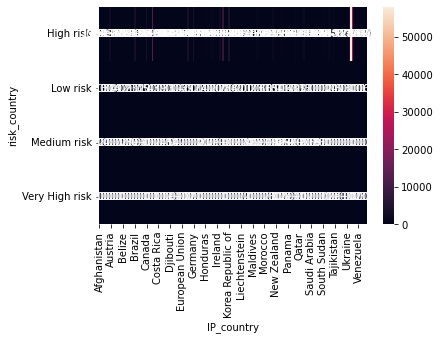

In [20]:
sns.heatmap(datasetCR, annot=True)

In [21]:
dataset.risk_country.unique()

array(['High risk', 'Very High risk', 'Medium risk', 'Low risk'],
      dtype=object)

In [22]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(datasetCR) 
# Print the p-value
print("p value\t\t\t", p)

print("Chi2 Contingency\t", c)

p value			 0.0
Chi2 Contingency	 453336.0


## Check for correlated variables with various numerical variables as dependent variable

In [23]:
model = ols('purchase_value ~ age_category + ip_address + seconds_since_signup + hour_of_the_day + month_purchase + weekday_purchase + risk_country + period_of_the_day + sex + quick_purchase', data = dataset).fit()               
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_category,4.0,1.860848e+03,465.211876,1.385890,0.235933
month_purchase,11.0,5.592780e+03,508.434589,1.514652,0.118319
weekday_purchase,6.0,3.353721e+03,558.953496,1.665151,0.125044
risk_country,3.0,7.147424e+02,238.247453,0.709751,0.546019
period_of_the_day,5.0,5.600741e+03,1120.148159,3.336978,0.005139
sex,1.0,1.926256e+02,192.625635,0.573841,0.448738
ip_address,1.0,5.010593e+00,5.010593,0.014927,0.902760
seconds_since_signup,1.0,2.002911e+01,20.029110,0.059668,0.807022
hour_of_the_day,1.0,4.724492e+01,47.244915,0.140745,0.707542
quick_purchase,1.0,1.000730e+03,1000.730053,2.981225,0.084238


In [24]:
model = ols('seconds_since_signup ~ age_category + ip_address + purchase_value + hour_of_the_day + month_purchase + weekday_purchase + risk_country + period_of_the_day + sex + quick_purchase', data = dataset).fit()               
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_category,4.0,1.612254e+13,4.030634e+12,0.636547,6.363854e-01
month_purchase,11.0,5.186753e+17,4.715230e+16,7446.633220,0.000000e+00
weekday_purchase,6.0,3.827906e+13,6.379844e+12,1.007551,4.181384e-01
risk_country,3.0,6.529903e+12,2.176634e+12,0.343750,7.936911e-01
period_of_the_day,5.0,3.235919e+13,6.471838e+12,1.022080,4.025605e-01
sex,1.0,1.023447e+13,1.023447e+13,1.616301,2.036102e-01
ip_address,1.0,3.094208e+12,3.094208e+12,0.488660,4.845268e-01
purchase_value,1.0,3.783946e+11,3.783946e+11,0.059759,8.068779e-01
hour_of_the_day,1.0,6.905715e+12,6.905715e+12,1.090601,2.963398e-01
quick_purchase,1.0,1.473478e+15,1.473478e+15,232.702363,1.679680e-52


## XGBoost


In [25]:
cat_encoded = pd.get_dummies(dataset[['source', 'browser', 'sex', 'month_purchase', 'weekday_purchase',
        'countries_from_device',
       'risk_country', 'quick_purchase', 'age_category', 'period_of_the_day', 'freq_same_purchase']])
numerical = dataset[['purchase_value', 'seconds_since_signup', 'age']]

data = pd.concat([cat_encoded, numerical], axis = 1)

In [26]:
X = data
y = dataset[['class']]

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [28]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

/Users/tohzhiaowei/opt/anaconda3/envs/bt4012/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [29]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

/Users/tohzhiaowei/opt/anaconda3/envs/bt4012/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/tohzhiaowei/opt/anaconda3/envs/bt4012/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tohzhiaowei/opt/anaconda3/envs/bt4012/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

[11:48:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

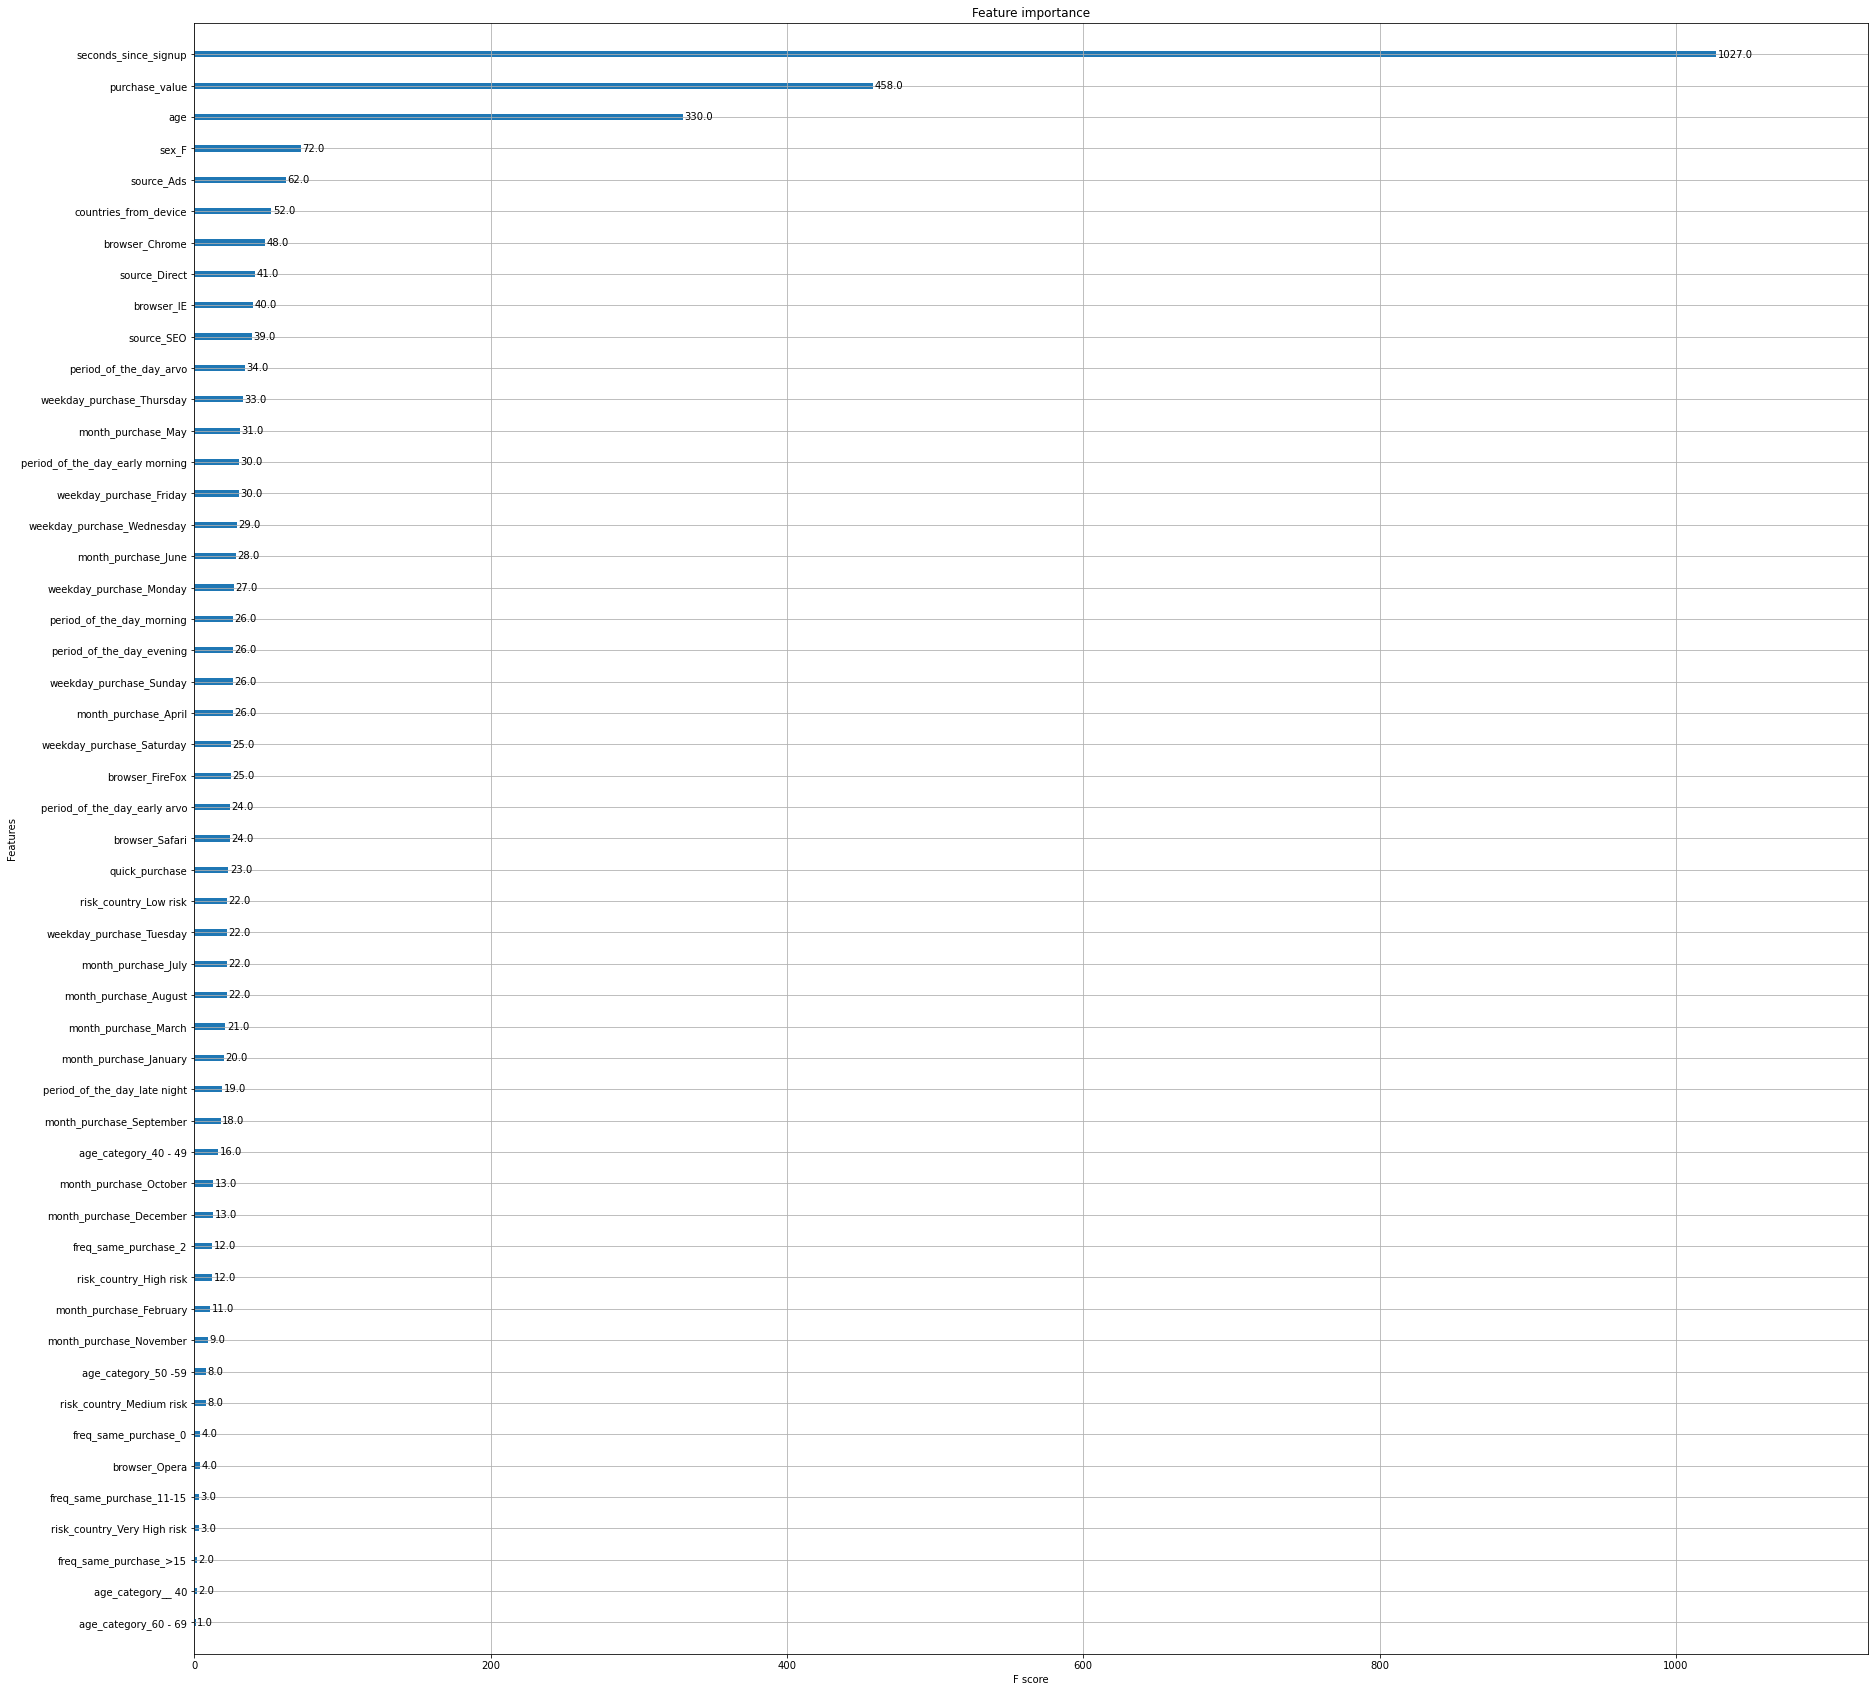

In [30]:
model = XGBClassifier()
model.fit(X_train, y_train)
# plot feature importance
plt.rcParams['figure.figsize'] = [30, 30]
display(plot_importance(model))

## RFE

In [31]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
selector = RFE(estimator = DecisionTreeClassifier(), n_features_to_select=13, step=1)
selector = selector.fit(X_train, y_train)

selector.ranking_

array([ 1, 44, 18, 20, 23,  1,  4,  1, 25,  1, 15,  1,  6, 24, 33, 22, 29,
        5,  7, 16, 10, 27, 17, 11,  3, 21,  2,  9, 14,  1,  1, 37, 38, 30,
       34, 42, 19, 28, 39, 26,  1, 12,  1,  8,  1, 13, 31, 32, 43, 41, 36,
       35, 40,  1,  1,  1])

In [32]:
ranking = pd.DataFrame([1, 43, 18, 20, 23,  1,  2,  1, 25,  4,  1, 13,  5, 24, 36, 22, 31,
       12, 10, 17, 14, 27, 16,  7,  1, 19,  1,  9, 15,  3,  1, 32, 39, 37,
       35, 44, 21, 28, 40, 26,  1,  8, 11,  6,  1,  1, 29, 30, 42, 41, 33,
       34, 38,  1,  1,  1], columns=["ranking"])
features = pd.DataFrame(['countries_from_device', 'quick_purchase', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox',
       'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M',
       'month_purchase_April', 'month_purchase_August',
       'month_purchase_December', 'month_purchase_February',
       'month_purchase_January', 'month_purchase_July', 'month_purchase_June',
       'month_purchase_March', 'month_purchase_May', 'month_purchase_November',
       'month_purchase_October', 'month_purchase_September',
       'weekday_purchase_Friday', 'weekday_purchase_Monday',
       'weekday_purchase_Saturday', 'weekday_purchase_Sunday',
       'weekday_purchase_Thursday', 'weekday_purchase_Tuesday',
       'weekday_purchase_Wednesday', 'risk_country_High risk',
       'risk_country_Low risk', 'risk_country_Medium risk',
       'risk_country_Very High risk', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category__ 40', 'period_of_the_day_arvo',
       'period_of_the_day_early arvo', 'period_of_the_day_early morning',
       'period_of_the_day_evening', 'period_of_the_day_late night',
       'period_of_the_day_morning', 'freq_same_purchase_0.0',
       'freq_same_purchase_2.0', 'freq_same_purchase_3.0',
       'freq_same_purchase_4.0', 'freq_same_purchase_11-15',
       'freq_same_purchase_5-10', 'freq_same_purchase_>15', 'purchase_value',
       'seconds_since_signup', 'age'], columns = ['features'])
feat_df = pd.concat([ranking, features], axis = 1)

In [33]:
rslt_df = feat_df.loc[feat_df['ranking'] == 1]

In [34]:
rslt_df

,ranking,features
0,1,countries_from_device
5,1,browser_Chrome
7,1,browser_IE
10,1,sex_F
24,1,weekday_purchase_Friday
26,1,weekday_purchase_Saturday
30,1,weekday_purchase_Wednesday
40,1,period_of_the_day_arvo
44,1,period_of_the_day_late night
45,1,period_of_the_day_morning


## Select the relevant columns for building the model

In [35]:
# data = one hot encoded
# dataset = original preprocessed data
final_df_X = data[['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'period_of_the_day_arvo',
        'purchase_value', 'seconds_since_signup']]

In [36]:
final_df_y = dataset[['class']]

In [37]:
data.columns

Index(['countries_from_device', 'quick_purchase', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox',
       'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M',
       'month_purchase_April', 'month_purchase_August',
       'month_purchase_December', 'month_purchase_February',
       'month_purchase_January', 'month_purchase_July', 'month_purchase_June',
       'month_purchase_March', 'month_purchase_May', 'month_purchase_November',
       'month_purchase_October', 'month_purchase_September',
       'weekday_purchase_Friday', 'weekday_purchase_Monday',
       'weekday_purchase_Saturday', 'weekday_purchase_Sunday',
       'weekday_purchase_Thursday', 'weekday_purchase_Tuesday',
       'weekday_purchase_Wednesday', 'risk_country_High risk',
       'risk_country_Low risk', 'risk_country_Medium risk',
       'risk_country_Very High risk', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
 

## Upsampling

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df_X, final_df_y, test_size=0.33, random_state=42)

In [60]:
train_df = pd.concat([X_train, y_train], axis=1)

from sklearn.utils import resample

not_fraud = train_df[train_df['class']==0]
fraud = train_df[train_df['class']==1]
# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled['class'].value_counts()

0    91777
1    91777
Name: class, dtype: int64

In [61]:
final_x_train = upsampled[['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'period_of_the_day_arvo',
        'purchase_value', 'seconds_since_signup']]

final_y_train = upsampled[['class']]

## Neural Network

- after upsampling 
- train dataset: final_x_train, final_y_train
- test dataset: X_test, y_test

- after standardise
- train dataset: x_scaled_train, final_y_train
- test dataset: x_scaled_test, y_test

with upsampling

In [87]:
# Standardize training data using StandardScalar method from sci-kit learn 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
stand = scaler.fit(final_x_train)
x_scaled_train = stand.transform(final_x_train)
x_scaled_test = stand.transform(X_test)
# print(pd.DataFrame(x_scaled_train).describe())
# print(pd.DataFrame(x_scaled_test).describe())

no upsampling

In [88]:
# Standardize training data using StandardScalar method from sci-kit learn 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
stand = scaler.fit(X_train)
x_scaled_train = stand.transform(X_train)
x_scaled_test = stand.transform(X_test)

# NN - 100 nodes, 6 hidden layers, epoch = 100, batch size = 50, loss = 'binary_crossentropy', optimizer = 'adam'

## no normalization and no dropout

In [89]:
# number of hidden nodes
H = 100
# input dimension
input_dim = 1
# num of epochs
num_epochs = 100

# create sequential multi-layer perceptron
model1 = Sequential()

# layer 0
model1.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 

# layer 1
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 2
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 3
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 4
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 5
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 6 (output layer)
model1.add(keras.layers.Dense(units=1, activation='sigmoid')) 

# configure the model
model1.compile(loss='binary_crossentropy', optimizer='adam')

# fit the model 
model_history1 = model1.fit(x_scaled_train, y_train, batch_size=50, epochs=num_epochs, verbose=0)

In [94]:
train_score = model1.evaluate(x_scaled_train, y_train, verbose=0)
print('Train loss:', train_score)
print('Train R2:', r2(y_train, model1.predict(x_scaled_train)))

test_score = model1.evaluate(x_scaled_test, y_test, verbose=0)
print('Test loss:', test_score)
print('Test R2:', r2(y_test, model1.predict(x_scaled_test)))

Train loss: 0.16860294342041016
3164/3164 [==============================] - 3s 904us/step
Train R2: 0.5068233082045748
Test loss: 0.2219877392053604
1559/1559 [==============================] - 1s 908us/step
Test R2: 0.44920074072985294


In [95]:
# predict probabilities for test set
yhat_probs = model1.predict(x_scaled_test, verbose=0)
# predict crisp classes for test set
yhat_classes = yhat_probs.argmax(axis=-1)

In [96]:
df = pd.DataFrame(yhat_classes, columns=['class'])
df[df['class']==1]

,class


In [97]:
# reduce to 1d array
# yhat_classes = yhat_classes[:, 0]
# yhat_classes = yhat_classes[:, 0]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

Accuracy: 0.906090
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
[[45184     0]
 [ 4683     0]]


/Users/tohzhiaowei/opt/anaconda3/envs/bt4012/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# NN - 100 nodes, 6 hidden layers, epoch = 100, batch size = 50, loss = 'binary_crossentropy', optimizer = 'adam'

## with normalization, 0.2 dropout

In [58]:
# number of hidden nodes
H = 100
# input dimension
input_dim = 1
# num of epochs
num_epochs = 100

# create sequential multi-layer perceptron
model1 = Sequential()

# layer 0
model1.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 

# batch normalization
model1.add(BatchNormalization())

model1.add(Dropout(0.2))

# layer 1
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 2
model1.add(keras.layers.Dense(units=H, activation='relu')) 

model1.add(Dropout(0.2))

# layer 3
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 4
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 5
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 6 (output layer)
model1.add(keras.layers.Dense(units=1, activation='sigmoid')) 

# configure the model
model1.compile(loss='binary_crossentropy', optimizer='adam')

# fit the model 
model_history1 = model1.fit(x_scaled_train, final_y_train, batch_size=50, epochs=num_epochs, verbose=0)

KeyboardInterrupt: 

In [ ]:
train_score = model1.evaluate(x_scaled_train, final_y_train, verbose=0)
print('Train loss:', train_score)
print('Train R2:', r2(final_y_train, model1.predict(x_scaled_train)))

test_score = model1.evaluate(x_scaled_test, y_test, verbose=0)
print('Test loss:', test_score)
print('Test R2:', r2(y_test, model1.predict(x_scaled_test)))

Train loss: 0.1785961389541626
3306/3306 [==============================] - 10s 3ms/step
Train R2: 0.4822152788515004
Test loss: 0.18418900668621063
1417/1417 [==============================] - 3s 2ms/step
Test R2: 0.4624015838020894


# NN - 100 nodes, 6 hidden layers, epoch = 100, batch size = 50, loss = 'binary_crossentropy', optimizer = 'adam'

## no normalization + 0.2 dropout

In [ ]:
# number of hidden nodes
H = 100
# input dimension
input_dim = 1
# num of epochs
num_epochs = 100

# create sequential multi-layer perceptron
model1 = Sequential()

# layer 0
model1.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 

# batch normalization
# model1.add(BatchNormalization())

model1.add(Dropout(0.2))

# layer 1
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 2
model1.add(keras.layers.Dense(units=H, activation='relu')) 

model1.add(Dropout(0.2))

# layer 3
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 4
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 5
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 6 (output layer)
model1.add(keras.layers.Dense(units=1, activation='sigmoid')) 

# configure the model
model1.compile(loss='binary_crossentropy', optimizer='adam')

# fit the model 
model_history1 = model1.fit(x_scaled_train, final_y_train, batch_size=50, epochs=num_epochs, verbose=0)

In [ ]:
train_score = model1.evaluate(x_scaled_train, final_y_train, verbose=0)
print('Train loss:', train_score)
print('Train R2:', r2(final_y_train, model1.predict(x_scaled_train)))

test_score = model1.evaluate(x_scaled_test, y_test, verbose=0)
print('Test loss:', test_score)
print('Test R2:', r2(y_test, model1.predict(x_scaled_test)))

Train loss: 0.17697210609912872
3306/3306 [==============================] - 5s 2ms/step
Train R2: 0.48700511994106566
Test loss: 0.18317310512065887
1417/1417 [==============================] - 2s 2ms/step
Test R2: 0.4680997838709856


In [65]:
def fit_model(optimizer, loss):
    # number of hidden nodes
    H = 100
    # input dimension
    input_dim = 1
    # num of epochs
    num_epochs = 100

    # create sequential multi-layer perceptron
    model1 = Sequential()

    # layer 0
    model1.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 

    # layer 1
    model1.add(keras.layers.Dense(units=H, activation='relu')) 

    # layer 2
    model1.add(keras.layers.Dense(units=H, activation='relu')) 

    # layer 3
    model1.add(keras.layers.Dense(units=H, activation='relu')) 

    # layer 4
    model1.add(keras.layers.Dense(units=H, activation='relu')) 

    # layer 5
    model1.add(keras.layers.Dense(units=H, activation='relu')) 

    # layer 6 (output layer)
    model1.add(keras.layers.Dense(units=1, activation='sigmoid')) 

    # configure the model
    model1.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    # fit the model 
    model_history1 = model1.fit(x_scaled_train, y_train, batch_size=50, epochs=num_epochs, verbose=0, validation_data=(x_scaled_test, y_test))

    # print score
    train_score = model1.evaluate(x_scaled_train, y_train, verbose=0)
    print(optimizer)
    print('Train loss:', train_score)
    print('Train R2:', r2(y_train, model1.predict(x_scaled_train)))

    test_score = model1.evaluate(x_scaled_test, y_test, verbose=0)
    print('Test loss:', test_score)
    print('Test R2:', r2(y_test, model1.predict(x_scaled_test)))
    
    # plot learning curves
    plt.plot(model_history1.history['accuracy'], label='train')
    plt.plot(model_history1.history['val_accuracy'], label='test')
    plt.title('opt='+optimizer, pad=-80)

    # for mean squared error
    # plot loss during training
    plt.subplot(211)
    plt.title('Loss'+loss, pad=-80)
    plt.plot(model_history1.history['loss'], label='train')
    plt.plot(model_history1.history['val_loss'], label='test')
    plt.legend()

    # if loss == 'mean_squared_error':
    #     # plot mse during training
    #     plt.subplot(212)
    #     plt.title('Mean Squared Error')
    #     plt.plot(model_history1.history['mean_squared_error'], label='train')
    #     plt.plot(model_history1.history['val_mean_squared_error'], label='test')
    #     plt.legend()
    #     plt.show()

sgd
Train loss: [0.04387807846069336, 0.9512847661972046]
3306/3306 [==============================] - 3s 853us/step
Train R2: 0.4821127840322327
Test loss: [0.046710092574357986, 0.9477875232696533]
1417/1417 [==============================] - 1s 825us/step
Test R2: 0.45194305380662614
rmsprop
Train loss: [0.05701686814427376, 0.9390232563018799]
3306/3306 [==============================] - 4s 1ms/step
Train R2: 0.3270367014672112
Test loss: [0.058949172496795654, 0.937133252620697]
1417/1417 [==============================] - 4s 3ms/step
Test R2: 0.3083401265826662
adagrad
Train loss: [0.048149943351745605, 0.9482690095901489]
3306/3306 [==============================] - 3s 990us/step
Train R2: 0.43169163459119964
Test loss: [0.05011077970266342, 0.9454051852226257]
1417/1417 [==============================] - 1s 945us/step
Test R2: 0.41204228118338815
adam
Train loss: [0.040344856679439545, 0.954215407371521]
3306/3306 [==============================] - 4s 1ms/step
Train R2: 0.52381

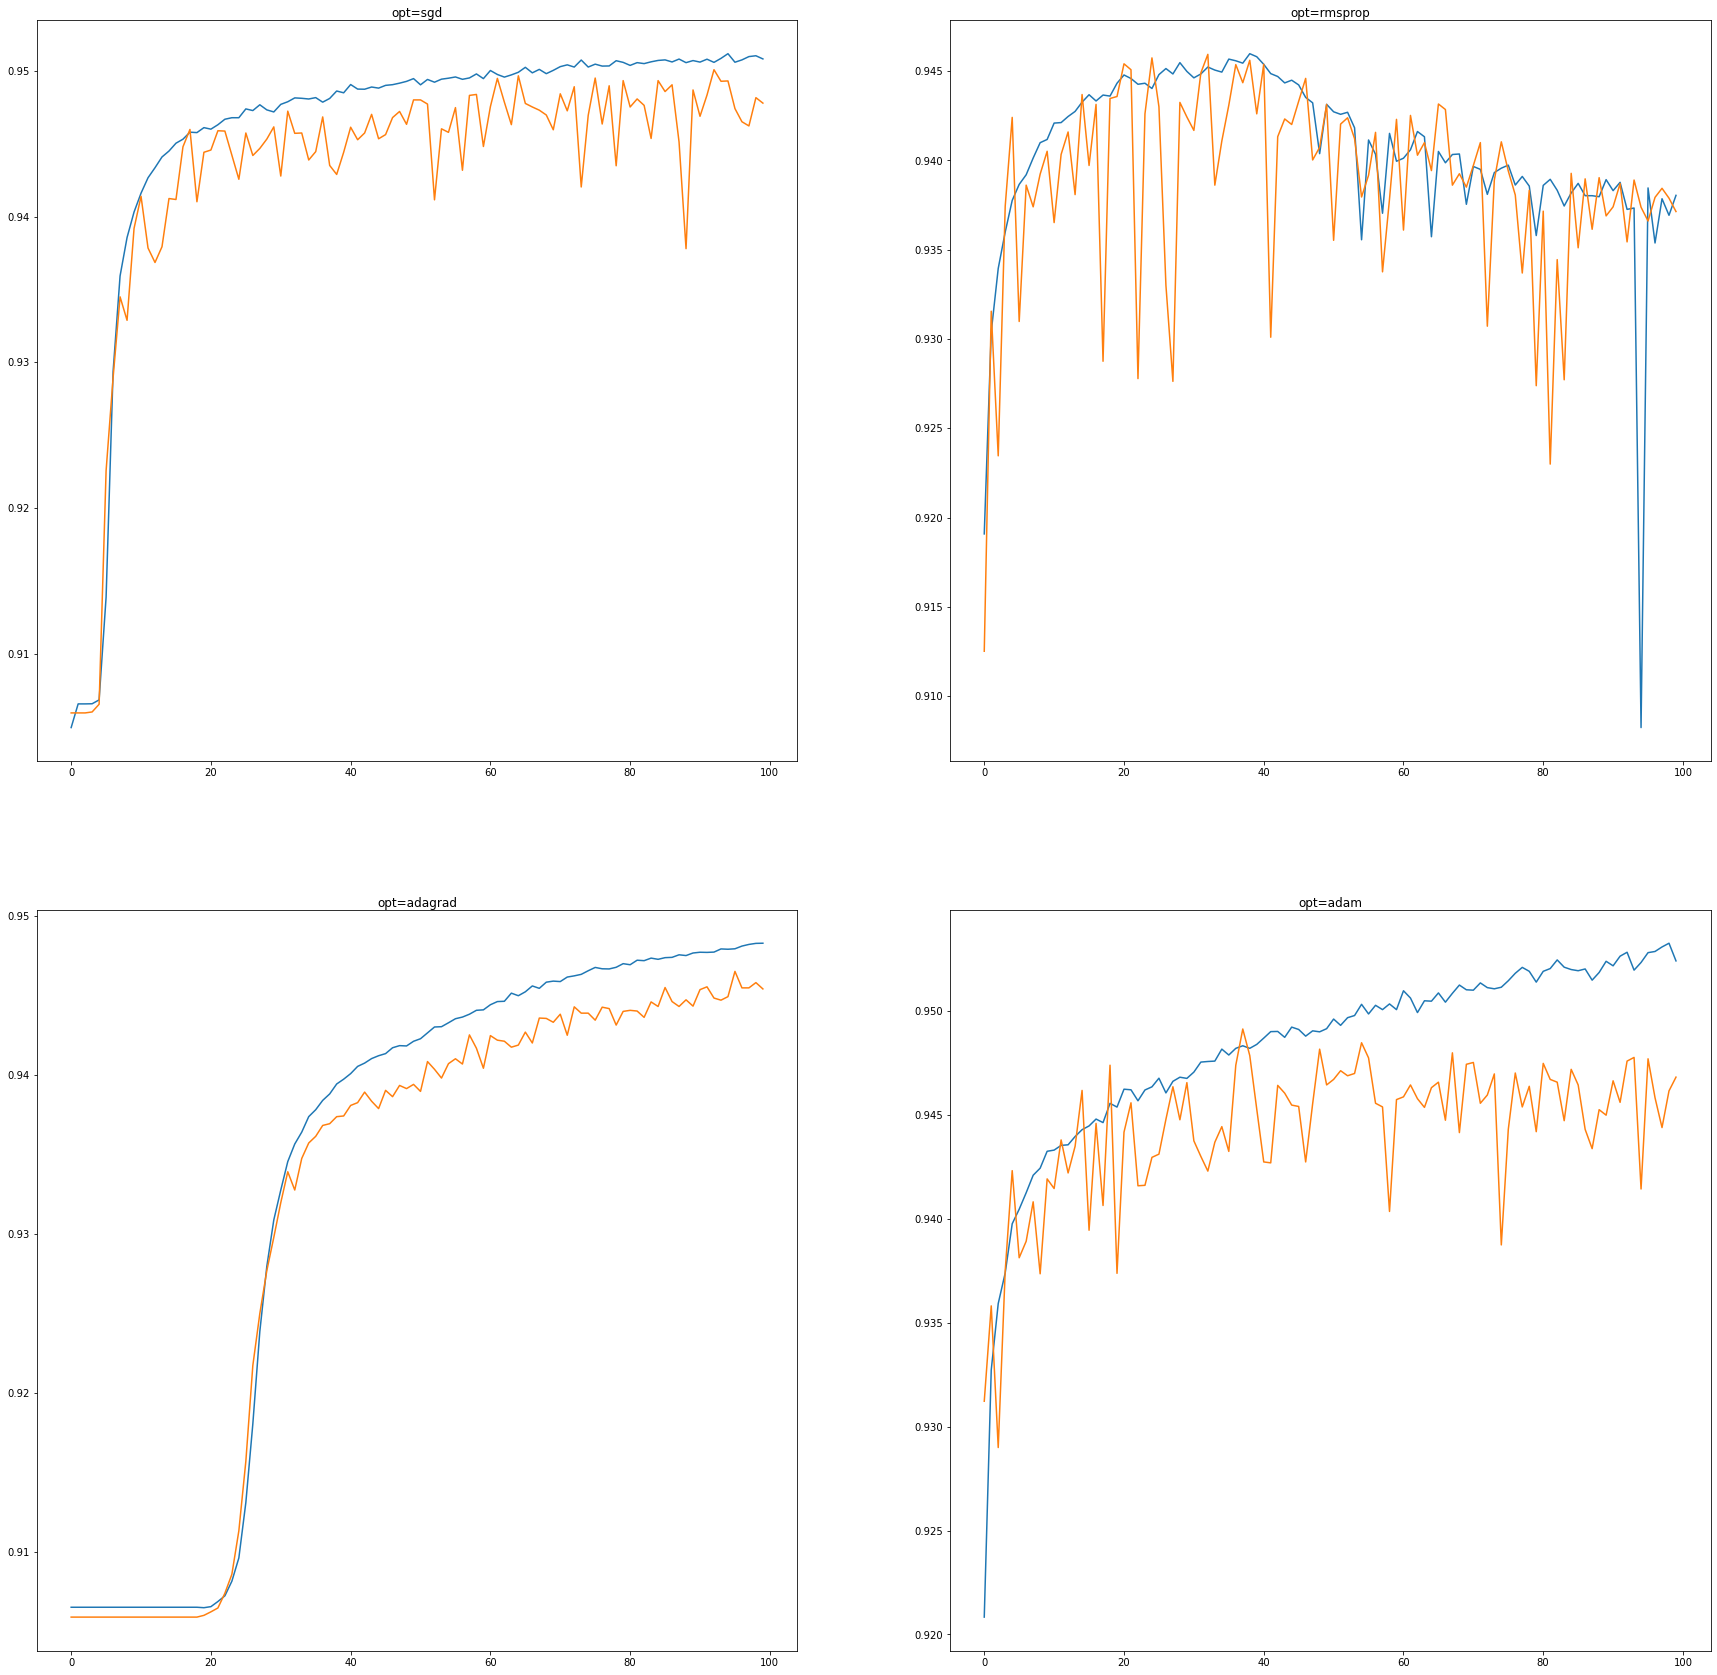

In [61]:
# create learning curves for different optimizers
momentums = ['sgd', 'rmsprop', 'adagrad', 'adam']
for i in range(len(momentums)):
	# determine the plot number
	plot_no = 220 + (i+1)
	plt.subplot(plot_no)
	# fit model and plot learning curves for an optimizer
	fit_model(momentums[i])
# show learning curves
plt.show()

adam
Train loss: [0.03932289779186249, 0.9558414816856384]
3306/3306 [==============================] - 3s 962us/step
Train R2: 0.5358758816228584
Test loss: [0.046833306550979614, 0.9481404423713684]
1417/1417 [==============================] - 1s 951us/step
Test R2: 0.45049751675424154


/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_10984/2523666035.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(211)
/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_10984/4112243834.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plot_no)


adam
Train loss: [0.1678066998720169, 0.953080952167511]
3306/3306 [==============================] - 11s 3ms/step
Train R2: 0.5110166462730878
Test loss: [0.1914319545030594, 0.9488904476165771]
1417/1417 [==============================] - 627s 443ms/step
Test R2: 0.4661122889095991


/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_10984/2523666035.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(211)


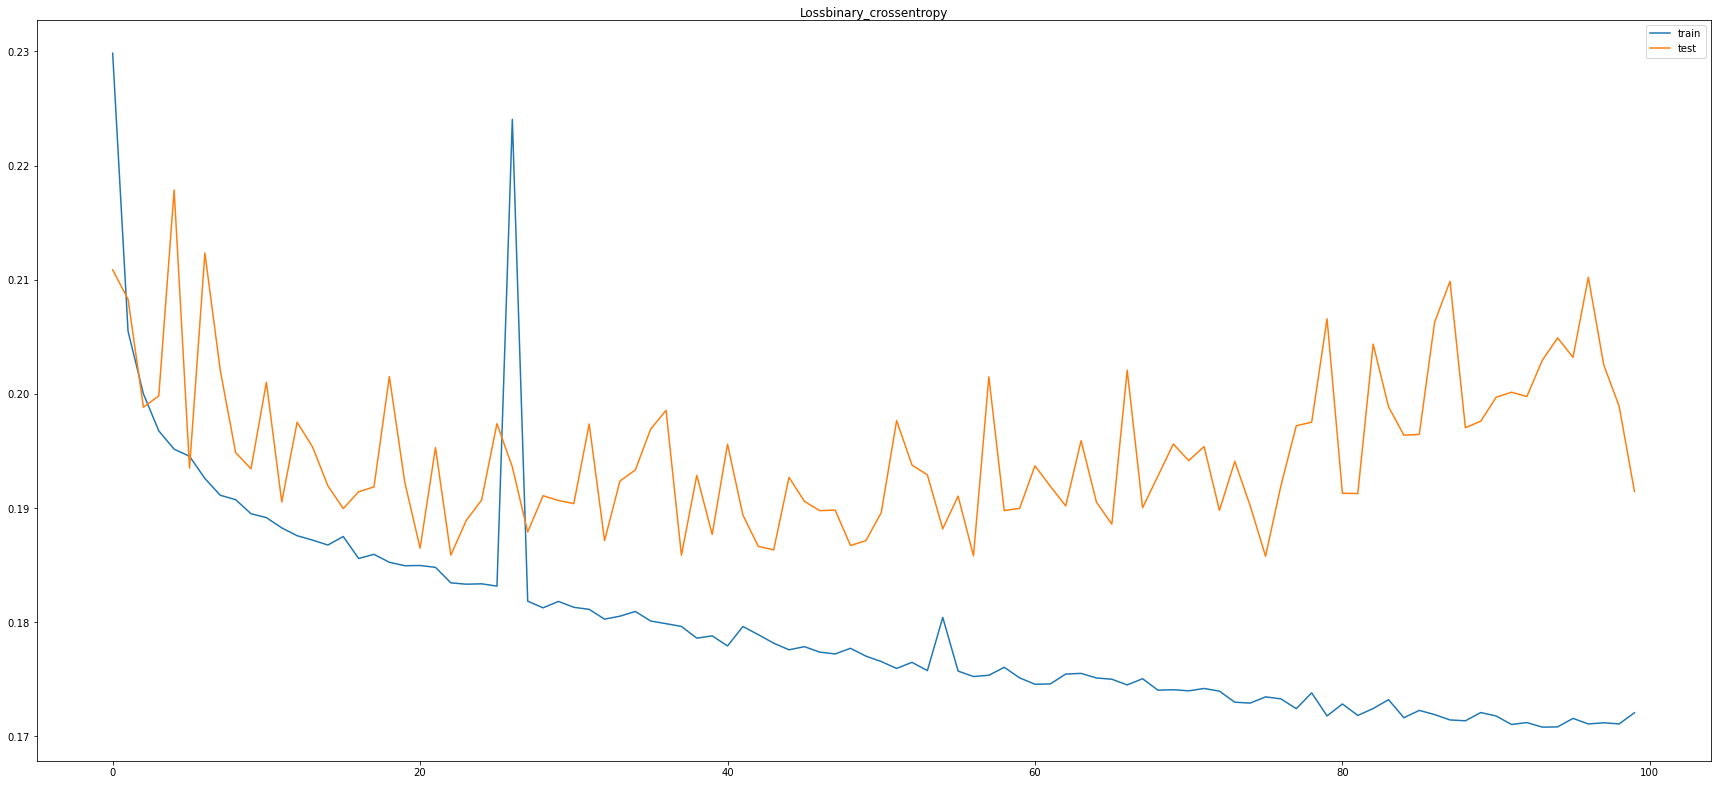

In [66]:
# create learning curves for different loss functions
loss_functions = ['mean_squared_error', 'binary_crossentropy']
for i in range(len(loss_functions)):
	# determine the plot number
	plot_no = 220 + (i+1)
	plt.subplot(plot_no)
	# fit model and plot learning curves for an optimizer
	fit_model('adam', loss_functions[i])
# show learning curves
plt.show()


# NN - 100 nodes, 6 hidden layers, loss=binary cross entropy, epochs = 100, batch_size=50

In [72]:
def fit_model(optimizer, loss):
    # number of hidden nodes
    H = 100
    # input dimension
    input_dim = 1
    # num of epochs
    num_epochs = 100

    # create sequential multi-layer perceptron
    model1 = Sequential()

    # layer 0
    model1.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 

    # batch normalization
    model1.add(BatchNormalization())

    model1.add(Dropout(0.2))

    # layer 1
    model1.add(keras.layers.Dense(units=H, activation='relu')) 

    # layer 2
    model1.add(keras.layers.Dense(units=H, activation='relu')) 

    model1.add(Dropout(0.2))

    # layer 3
    model1.add(keras.layers.Dense(units=H, activation='relu')) 

    # layer 4
    model1.add(keras.layers.Dense(units=H, activation='relu')) 

    # layer 5
    model1.add(keras.layers.Dense(units=H, activation='relu')) 

    # layer 6 (output layer)
    model1.add(keras.layers.Dense(units=1, activation='sigmoid')) 

    # configure the model
    model1.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    # fit the model 
    model_history1 = model1.fit(x_scaled_train, y_train, batch_size=50, epochs=num_epochs, verbose=0, validation_data=(x_scaled_test, y_test))

    # print score
    train_score = model1.evaluate(x_scaled_train, y_train, verbose=0)
    print(optimizer)
    print('Train loss:', train_score)
    print('Train R2:', r2(y_train, model1.predict(x_scaled_train)))

    test_score = model1.evaluate(x_scaled_test, y_test, verbose=0)
    print('Test loss:', test_score)
    print('Test R2:', r2(y_test, model1.predict(x_scaled_test)))
    
    # plot learning curves
    plt.plot(model_history1.history['accuracy'], label='train')
    plt.plot(model_history1.history['val_accuracy'], label='test')
    plt.title('opt='+optimizer, pad=-80)

    # plot loss during training
    # plt.subplot(211)
    # plt.title('Loss'+loss+' '+optimizer, pad=-80)
    # plt.plot(model_history1.history['loss'], label='train')
    # plt.plot(model_history1.history['val_loss'], label='test')
    # plt.legend()

sgd
Train loss: [0.17609669268131256, 0.949857234954834]
3306/3306 [==============================] - 3s 885us/step
Train R2: 0.48497501590349745
Test loss: [0.18239811062812805, 0.9484272003173828]
1417/1417 [==============================] - 1s 838us/step
Test R2: 0.4697088892244332
rmsprop
Train loss: [0.278276652097702, 0.9065400958061218]
3306/3306 [==============================] - 4s 1ms/step
Train R2: 0.07406400658905132
Test loss: [0.27913543581962585, 0.9059205055236816]
1417/1417 [==============================] - 2s 1ms/step
Test R2: 0.07442689814886083
adagrad
Train loss: [0.2196519672870636, 0.9377186298370361]
3306/3306 [==============================] - 4s 1ms/step
Train R2: 0.31725014683235586
Test loss: [0.2241058647632599, 0.9351259469985962]
1417/1417 [==============================] - 2s 1ms/step
Test R2: 0.3038464326824162
adam
Train loss: [0.19284340739250183, 0.94212406873703]
3306/3306 [==============================] - 5s 1ms/step
Train R2: 0.41777657545143587

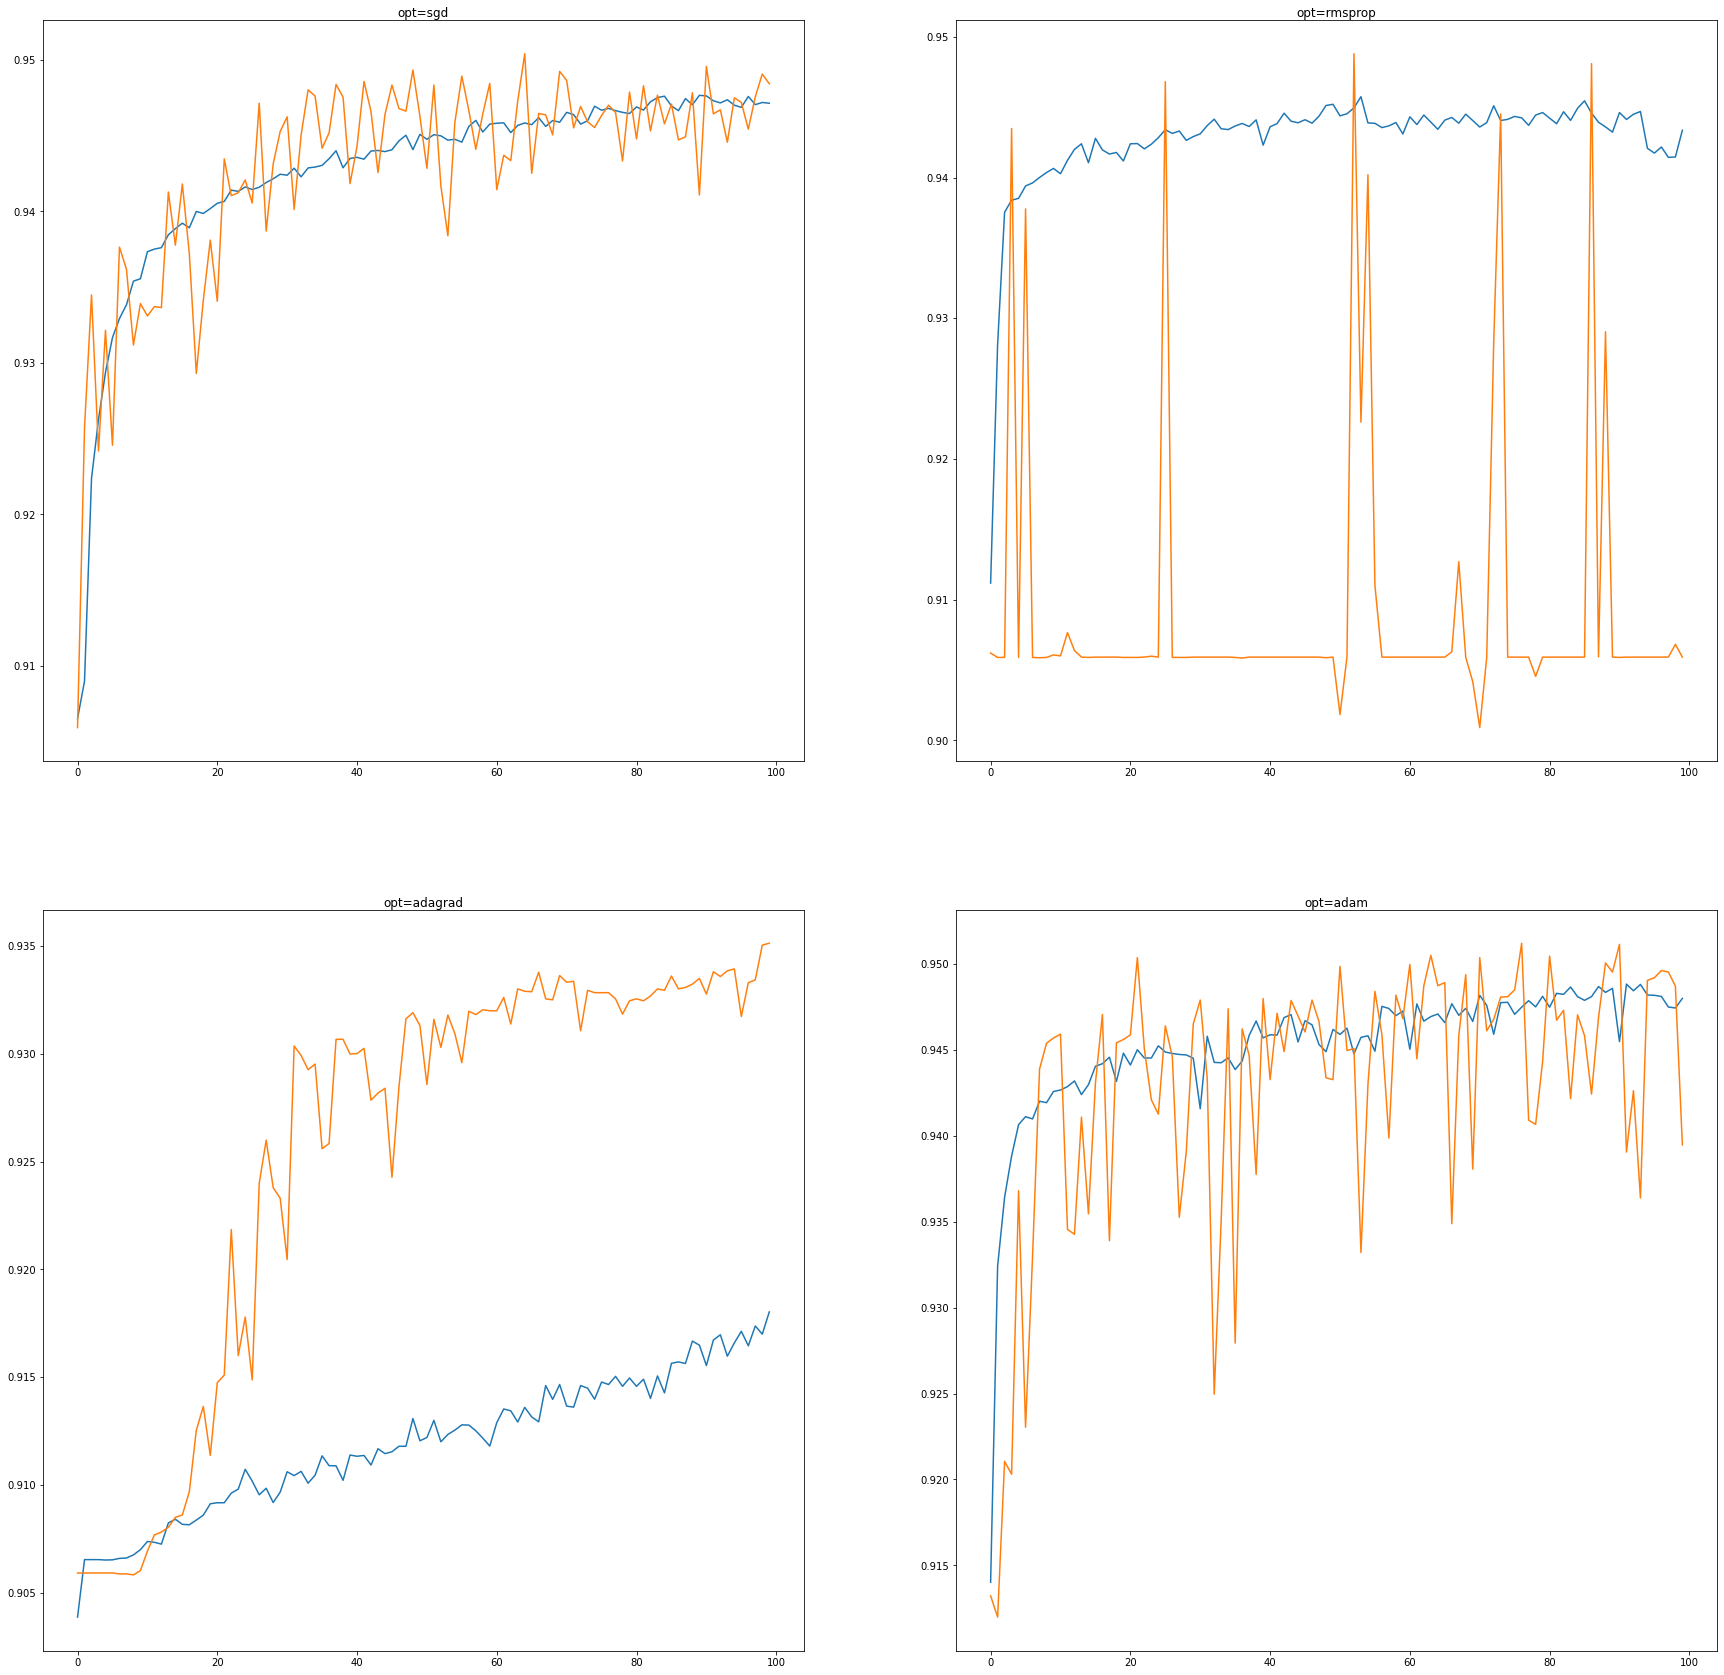

In [73]:
# create learning curves for different optimizers
momentums = ['sgd', 'rmsprop', 'adagrad', 'adam']
for i in range(len(momentums)):
	# determine the plot number
	plot_no = 220 + (i+1)
	plt.subplot(plot_no)
	# fit model and plot learning curves for an optimizer
	fit_model(momentums[i], 'binary_crossentropy')
# show learning curves
plt.show()